In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Implementation of Easy21

Below I create an environment implementing the game.
- reset(): generates the start state
- _draw_card() -> card: returns a card represented as a dictionary with "value" and "colour" keys
- step(action): -> (state, reward, terminated): takes an action (either "stick" or "hit") and returns a new state, a rewards (either -1, 0, or +1), and a Boolean denoting whether the terminal state has been reached

In [2]:
class Environment():
    def __init__(self):
        self.state = {
            "dealer_showing" : np.random.choice(np.arange(1, 11)),
            "player_sum": np.random.choice(np.arange(1, 11))
        }
        
    def reset(self):
        self.state = {
            "dealer_showing" : np.random.choice(np.arange(1, 11)),
            "player_sum": np.random.choice(np.arange(1, 11))
        }

        return self.state.copy()
        
    
    def _draw_card(self):
        value = np.random.choice(np.arange(1, 11))
        colour = np.random.choice(["red", "black"], p=[1/3, 2/3])
        card = {
            "value": value,
            "colour": colour,
        }
        return card
    
    
    def step(self, action):
        if action == "hit":
            card = self._draw_card()
            # Update the state based on the drawn card
            if card["colour"] == "black":
                self.state["player_sum"] = self.state["player_sum"] + card["value"]
            else:
                self.state["player_sum"] = self.state["player_sum"] - card["value"]

            # Terminate and return -1 if player went bust
            if self.state["player_sum"] > 21 or self.state["player_sum"] < 1:
                reward = -1
                terminated = True
            # Otherwise return a reward of 0
            else:
                terminated = False
                reward = 0
        
        if action == "stick":
            # We can already terminate as the dealer will keep drawing until a conclusion is reached
            terminated = True
            dealer_sum = self.state["dealer_showing"]
    
            while dealer_sum < 17:
                dealer_card = self._draw_card()
                if dealer_card["colour"] == "black":
                    dealer_sum = dealer_sum + dealer_card["value"]
                else:
                    dealer_sum = dealer_sum - dealer_card["value"]

            # Player wins either by dealer going bust or by having a greater sum
            if (dealer_sum > 21 or dealer_sum < 1) or self.state["player_sum"] > dealer_sum:
                reward = 1
            # Player draws
            elif dealer_sum == self.state["player_sum"]:
                reward = 0
            # Player loses
            else:
                reward = -1
    
        return self.state.copy(), reward, terminated


# Question 2: Monte-Carlo Control
Below I implement every-visit MC Control to easy21. I use a time-varying step-size, $\alpha_t = 1/N(S_t, a_t)$ and an $\epsilon$-greedy strategy with $\epsilon_t=N_0/(N_0+N(S_t))$, where $N_0=100$ is a constant.

In [9]:
# Some helper functions
def convert_to_idxs(s):
    """Converts the state to indices for easy N, Q, V updating"""
    s_idx1 = s["player_sum"]-1
    s_idx2 = s["dealer_showing"]-1
    return s_idx1, s_idx2


def epsilon_greedy(epsilon=0.05):
    """Selects an action maximising Q(s,a) with probability 1-epsilon. Random uniform otherwise"""
    s_idx1, s_idx2 = convert_to_idxs(env.state)
    
    if np.random.uniform() < (1 - epsilon):
            return np.random.choice(["hit", "stick"])

    if Q[s_idx1, s_idx2, 0] > Q[s_idx1, s_idx2, 1]:
        return "hit" 
    else:
        return "stick"


def calculate_epsilon():
    """Calculates epsilon for the current state"""
    N_s = N[convert_to_idxs(env.state)].sum()
    return N_0 / (N_0 + N_s)


In [6]:
# Monte Carlo Control
Q = np.zeros((21, 10, 2))
N = np.zeros_like(Q)
N_0 = 100
env = Environment()

for _ in range(1000000):
    episode = {
        "states":[env.reset()],
        "rewards":[0],
        "actions":[],
    }
    
    terminated = False
    
    while not terminated:
        action = epsilon_greedy(epsilon=calculate_epsilon())
        state, reward, terminated = env.step(action)
        if not terminated:
            episode["states"].append(state.copy())
        episode["rewards"].append(reward)
        episode["actions"].append(action)

    for t, (s, a) in enumerate(zip(episode["states"], episode["actions"])):
        s_idx1, s_idx2 = convert_to_idxs(s)
        a_idx = 0 if a == "hit" else 1
        
        N[s_idx1, s_idx2, a_idx] += 1
        G = sum(episode["rewards"][t:])
        Q[s_idx1, s_idx2, a_idx] += (1/N[s_idx1, s_idx2, a_idx]) * (G-Q[s_idx1, s_idx2, a_idx])

V = Q.max(axis=2)

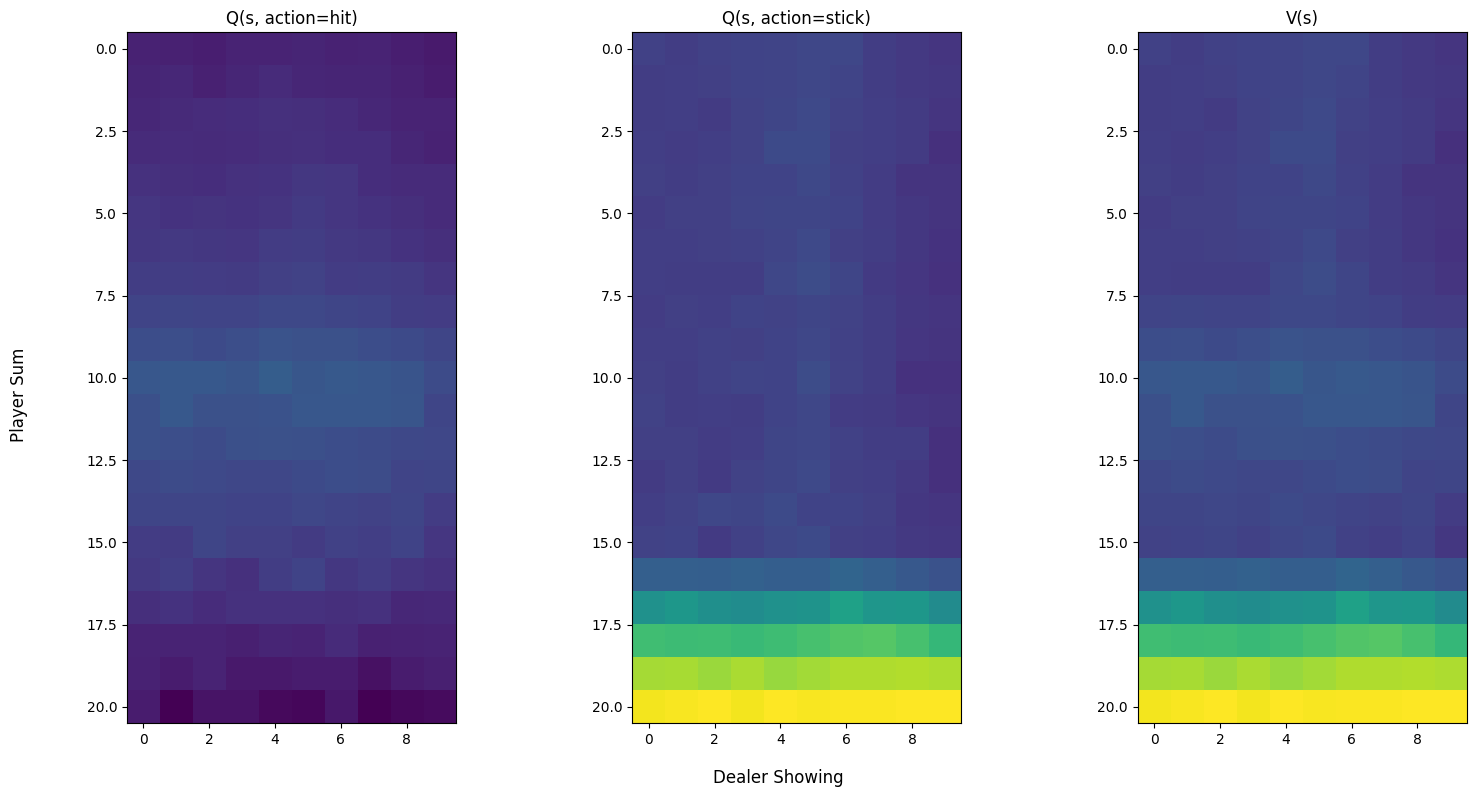

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
axs[0].imshow(Q[:, :, 0], vmin=Q.min(), vmax=Q.max())
axs[0].set_title("Q(s, action=hit)")
axs[1].imshow(Q[:, :, 1], vmin=Q.min(), vmax=Q.max())
axs[1].set_title("Q(s, action=stick)")
axs[2].imshow(V, vmin=Q.min(), vmax=Q.max())
axs[2].set_title("V(s)")
fig.supxlabel('Dealer Showing')
fig.supylabel('Player Sum')
fig.tight_layout()
plt.show()